In [1]:

import os
import gym
import cma
import math
import torch
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from tqdm import tqdm
from pprint import pprint
from datetime import datetime
from scipy.optimize import minimize
from joblib import Parallel, delayed
from IPython.display import display

from gym.wrappers import TimeLimit
from gym.envs.classic_control import PendulumEnv

from stable_baselines3 import DDPG, A2C, PPO, TD3
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise

from mdp_extras import vi, OptimalPolicy, padding_trick, UniformRandomCtsPolicy, PaddedMDPWarning, Linear
from mdp_extras.envs import (
    CustomPendulumEnv,
    VonMisesNormalBasis,
    pendulum_obs_to_state
)

from unimodal_irl import sw_maxent_irl, sw_maxent_irl_modelfree, mean_ci, ile_evd, inner_angle


In [2]:



#env = gym.make("Pendulum-v0")
max_timesteps = 200
env = PendulumEnv()
env = TimeLimit(env, max_timesteps)
gamma = 0.99

# Load trained DDPG policy from rl-baselines3-zoo
model = DDPG.load(
    os.path.join("rl-trained-agents/ddpg/Pendulum-v0_1/Pendulum-v0.zip"),
    env=env,
    custom_objects=dict(learning_rate=0.001)
)


C:\Users\snoswell\Miniconda3\envs\py38\lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [3]:

def preview_policy(policy, num_eps=2):
    for _ in range(num_eps):
        gain = 0
        obs = env.reset()
        for t in range(max_timesteps):
            a, _ = policy.predict(obs)
            obs, r, done, info = env.step(a)
            env.render()
            gain += r
            if done:
                break
        env.close()
        print("Gain = ", gain)


In [4]:

# Collect demonstrations from expert policy
num_demos = 20
demos = []
for _ in range(num_demos):
    obs = env.reset()
    traj = []
    while True:
        state = pendulum_obs_to_state(obs)
        action, _ = model.predict(obs)
        traj.append((state, action))
        obs, reward, done, info = env.step(action)
        #env.render()
        if done:
            break
    demos.append(traj)
    #env.close()


[[1.37228931e-04 2.60523678e-01 2.81397210e+01 1.74939481e-01
  3.41200528e-05]
 [2.31296580e-01 6.76056018e-01 2.59988624e-01 1.51151544e-01
  8.23808584e-03]
 [5.44339201e-01 1.68049880e-01 3.72317137e-01 2.68556664e-01
  1.39230871e-01]
 [3.83788671e-01 3.49575355e-01 4.83818746e-01 4.43847770e-01
  1.64711023e-01]
 [1.14475265e-02 3.09312827e-01 3.71189662e-01 3.37865406e-01
  7.78023274e-02]]


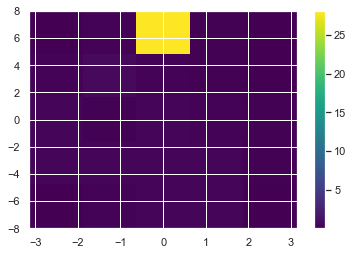

In [5]:

basis_dim = 5
phi = VonMisesNormalBasis(num=basis_dim, kappa=10, std=1.0)

# Visualise feature function
# num = 20
# t = np.linspace(-np.pi, np.pi, num)
# td = np.linspace(-8.0, 8.0, num)

# X, Y = np.meshgrid(t, td)
# Z = np.zeros([X.shape[0], X.shape[1], basis_dim ** 2])
# for id0 in range(X.shape[0]):
#     for id1 in range(X.shape[1]):
#         _x = X[id0, id1]
#         _y = Y[id0, id1]
#         Z[id0, id1] = phi([_x, _y])

# import matplotlib.pyplot as plt

# for _idx in range(basis_dim ** 2):
#     plt.figure()
#     _Z = Z[:, :, _idx]
#     plt.contour(X, Y, _Z)
#     plt.show()
#     plt.close()

phi_bar = phi.demo_average(demos, gamma)

print(phi_bar.reshape(basis_dim, -1))

def viz_soln(x, cmap="RdBu"):
    """Visualize a solution vector"""
    #plt.figure(figsize=(7, 6), dpi=300)
    plt.figure()
    sns.set()
    plt.imshow(x.reshape(basis_dim, -1), aspect="auto", extent=(-np.pi, np.pi, -8.0, 8.0))
    plt.set_cmap(cmap)
    plt.colorbar()
    plt.show()

# Visualize expert's feature expectation
viz_soln(phi_bar, "viridis")


In [6]:

# Build a very fast approximate feature lookup table
t_bounds = np.array([-np.pi, np.pi])
t_delta = t_bounds[1] - t_bounds[0]
td_bounds = np.array([-8, 8])
td_delta = td_bounds[1] - td_bounds[0]

num_disc = 1000

def s2int(s):
    t, td = s
    t_idx = int(np.round((t - t_bounds[0]) / t_delta * (num_disc - 1)))
    td_idx = int(np.round((td - td_bounds[0]) / td_delta * (num_disc - 1)))
    ttd_idx = td_idx + num_disc * t_idx
    ttd_idx = min(max(ttd_idx, 0), (num_disc * num_disc) - 1)
    return ttd_idx

# # Sweep state space
# thetas = np.linspace(*t_bounds, num_disc, endpoint=False)
# theta_dots = np.linspace(*td_bounds, num_disc)
# state_sweep = [np.array(p) for p in it.product(thetas, theta_dots)]

# print("Building feature LUT", flush=True)
# phi_lut = []
# for s in tqdm(state_sweep):
#     phi_lut.append(phi(s))

# # Save to disk
# with open("phi-s-lut.pkl", "wb") as file:
#     pickle.dump(phi_lut, file)
#del phi_lut

# Load from disk
with open("phi-s-lut.pkl", "rb") as file:
    phi_lut = pickle.load(file)



# Value function is given by:

$$
v_\pi(s) \triangleq \mathbb{E}_\pi\left[
    \sum_{k=0}^\infty \gamma^k r(s_{t+k+1}) \mid s_t = s
\right]
$$

Therfore, for a given policy we can approximate this by,

$$
v_\pi(s) \approx \frac{1}{|M|} \sum_{i=1}^M
\left[
    r(s) + r(s') + \dots \mid T, \pi
\right];
\qquad\qquad \tau_i \sim \pi
$$

This approximation will have much lower variance for a deterministic policy, and will be exact up to numerical rounding for the case of a deterministic policy AND detemrinistic dynamics.


In [7]:


def approx_state_value(model, s, num_samples=1, gamma=1.0, r_custom=None):
    """Approximately compute the value of s under pi
    
    Args:
        pi (class): Policy object with a .predict() method matching the stable-baselines API
        s (numpy array): State to estimate value from
        
        num_samples (int): Number of samples to estimate value with. For
            determinstic policies and transition dynamics this can be set to 1.
        gamma (float): Discount factor
        r_custom (mdp_extras.RewardFunction): Custom reward function to use
    
    Returns:
        (float): State value estimate
    """
    pi = model
    
    episode_returns = []
    for _ in range(num_samples):
        # XXX Force initial state
        env.reset()
        env.unwrapped.state = s
        obs = env.unwrapped._get_obs()
        done = False
        ep_rewards = []
        while not done:
            a = pi.predict(obs, deterministic=True)[0]
            obs, reward, done, info = env.step(a)
            if r_custom is not None:
                # Use custom reward function
                state = pendulum_obs_to_state(obs)
                reward = r_custom(phi(state))
            ep_rewards.append(reward)
            if done:
                break
        ep_rewards = np.array(ep_rewards)
        gammas = gamma ** np.arange(len(ep_rewards))
        episode_return = gammas @ ep_rewards
        episode_returns.append(episode_return)
    
    return np.mean(episode_returns)


def approx_policy_value(model, start_state_disc_dim=10, num_samples=1, gamma=1.0, r_custom=None, n_jobs=8):
    """Approximately compute the value pi under the starting state distribution
    
    Args:
        pi (class): Policy object with a .predict() method matching the stable-baselines API
    
        start_state_disc_dim (int): How fine to discretize each dimension of the MDP starting
            state distribution support. For Pundulum-v0, 10 seems to be sufficient for accurately
            measuring policy value (at least for the optimal policy)
        num_samples (int): Number of samples to estimate value with. For
            determinstic policies and transition dynamics this can be set to 1.
        gamma (float): Discount factor
        r_custom (mdp_extras.RewardFunction): Custom reward function to use
        n_jobs (int): Number of parallel workers to spin up for estimating value
        
    Returns:
        (float): Approximate value of pi under the MDP's start state distribution
    """
    # Compute a set of states that span and discretize the continuous uniform start state distribution
    theta_bounds = np.array([-np.pi, np.pi])
    theta_delta = 0.5 * (theta_bounds[1] - theta_bounds[0]) / start_state_disc_dim
    theta_bounds += np.array([theta_delta, -theta_delta])
    thetas = np.linspace(theta_bounds[0], theta_bounds[1], start_state_disc_dim)
    theta_dots = np.linspace(-1, 1, start_state_disc_dim)
    start_states = [np.array(p) for p in it.product(thetas, theta_dots)]
    
    # Spin up a bunch of workers to process the starting states in parallel
    values = Parallel(n_jobs=n_jobs)(
        delayed(approx_state_value)(model, state, num_samples, gamma, r_custom)
        for state in start_states
    )
    return np.mean(values)

# What is the value of the optimal policy?
#pi_gt_v = approx_policy_value(model)
#print(pi_gt_v)
# -144 is *just* sufficient to make it to the OpenAI Gym leaderboard - so we're in the right ball-park

# Best value from OpenAI Leaderboard: https://github.com/openai/gym/wiki/Leaderboard#pendulum-v0
pi_gt_v = -123.11


def evd(model, gamma, n_jobs=8):
    """Compute approximate expected value difference for a learned optimal policy
    
    Args:
        learned_td3_model_path (str): Filename for saved model parameters
        
        gamma (float): Discount factor
        
    Returns:
        (float): Expected value difference of the given policy
    """
    v_pi = approx_policy_value(model, gamma=gamma, n_jobs=n_jobs)
    evd = pi_gt_v - v_pi
    return evd



In [8]:

def approx_opt_pol(theta, mdl_fname="mdl.td3"):
    """Compute an approximate optimal policy for a given Pendulum linear reward parameter vector
    
    Args:
        theta (numpy array): Reward parameter vector
        
        mdl_fname (str): String where to save model to
    
    Returns:
        (float): Expected Value Difference of the policy before training
        (torch.model): Trained policy on CPU device, ready for evaluating
    """
    
    # Build tmp environment for training
    mdl = TD3(
        "MlpPolicy",
        env,
        verbose=0,
        tensorboard_log="./tb-log/",
        # Initially load on CPU so we can evaluate quickly
        device="cpu",

        # Non-standard params from rl-baselines3-zoo
        # https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/td3.yml
        policy_kwargs=dict(net_arch=[400, 300]),
        action_noise=NormalActionNoise(0, 0.1),
        learning_starts=10000,
        buffer_size=200000,
        gamma=gamma
    )
    print("PRE-training preview")
    preview_policy(mdl)
    mdl.save(mdl_fname)
    pre_train_evd = evd(mdl, gamma, n_jobs=1)
    
    # Re-load to get onto GPU for training
    custom_reward = lambda s: theta @ phi_lut[s2int(s)]
    _env = Monitor(TimeLimit(CustomPendulumEnv(reward_fn=custom_reward), max_timesteps), filename="pendulum-log")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mdl_gpu = TD3.load(mdl_fname, env=_env, device=device)
    mdl_gpu.learn(
        total_timesteps=1e5,
        log_interval=5
    )
    mdl_gpu.save(mdl_fname)
    
    mdl_out = TD3.load(mdl_fname, env=env, device="cpu")
    print("POST-training preview")
    preview_policy(mdl_out)
    post_train_evd = evd(mdl_out, gamma, n_jobs=1)
    
    return pre_train_evd, mdl_out, post_train_evd


In [ ]:

experimental_data = []
num_repeats = 10

m_vals = 2 ** np.arange(10 + 1)
for num_sampled_paths in m_vals:

    # Initial point
    x0 = np.zeros(len(phi))

    # Bounds
    bounds = [[-1.0, 1.0] for _ in range(len(phi))]
    
    # Importance sampling policy
    pi_ref = UniformRandomCtsPolicy((-2.0, 2.0))
    
    for repeat in range(num_repeats):
        
        print(f"Up to {num_sampled_paths}-{repeat}")

        # Get importance sampling dataset
        pi_ref_demos = []
        max_path_length = max_timesteps
        for _ in range(num_sampled_paths):
            path_len = np.random.randint(1, high=max_path_length + 1)
            path = []
            obs = env.reset()
            s = pendulum_obs_to_state(obs)
            while len(path) < path_len - 1:
                a = pi_ref.predict(s)[0]
                path.append((s, a))
                obs, r, done, _ = env.step(a)
                s = pendulum_obs_to_state(obs)
            path.append((s, None))
            pi_ref_demos.append(path)

        # Pre-compute sampled path feature expectations
        pi_ref_demo_phis_precomputed = [
            phi.onpath(p, gamma)
            for p in pi_ref_demos
        ]

        # Solve with biased gradient
        res = minimize(
            sw_maxent_irl_modelfree,
            x0,
            args=(gamma, phi, phi_bar, max_path_length, pi_ref, pi_ref_demos, False, pi_ref_demo_phis_precomputed),
            method='L-BFGS-B',
            jac=True,
            bounds=bounds,
            options=dict(disp=True)
        )
        theta = res.x
        pre_evd, mdl, post_evd = approx_opt_pol(theta)
        experimental_data.append([
            # Importance sampling policy
            "Uniform",
            # How many sampled paths?
            num_sampled_paths,
            # Optimizer and gradient type
            "L-BFGS-B-is",
            # EVD before and after training
            pre_evd,
            post_evd,
            # Learned reward
            theta,
            # Optimizer result/information
            res
        ])

        # Nelder Mead doesn't work - the scipy implementation doesn't support bounds or callback termination signals
        # See: https://github.com/scipy/scipy/issues/9412

        # Solve with L-BFGS-B two-point
        res = minimize(
            sw_maxent_irl_modelfree,
            x0,
            args=(gamma, phi, phi_bar, max_path_length, pi_ref, pi_ref_demos, True, pi_ref_demo_phis_precomputed),
            method='L-BFGS-B',
            jac='2-point',
            bounds=bounds,
            options=dict(disp=True)
        )
        theta = res.x
        pre_evd, mdl, post_evd = approx_opt_pol(theta)
        experimental_data.append([
            # Importance sampling policy
            "Uniform",
            # How many sampled paths?
            num_sampled_paths,
            # Optimizer and gradient type
            "L-BFGS-B-2point",
            # EVD before and after training
            pre_evd,
            post_evd,
            # Learned reward
            theta,
            # Optimizer result/information
            res
        ])

        # Solve with CMA
        theta, es = cma.fmin2(
            sw_maxent_irl_modelfree,
            x0,
            0.5,
            args=(gamma, phi, phi_bar, max_path_length, pi_ref, pi_ref_demos, True, pi_ref_demo_phis_precomputed),
            options=dict(bounds=bounds[0])
        )
        pre_evd, mdl, post_evd = approx_opt_pol(theta)
        experimental_data.append([
            # Importance sampling policy
            "Uniform",
            # How many sampled paths?
            num_sampled_paths,
            # Optimizer and gradient type
            "CMA-ES",
            # EVD before and after training
            pre_evd,
            post_evd,
            # Learned reward
            theta,
            # Optimizer result/information
            None
        ])
        
        # Save checkpoint
        with open("out.pkl", "wb") as file:
            pickle.dump(experimental_data, file)

df = pd.DataFrame(
    experimental_data,
    columns=[
        "IS Policy",
        "IS Budget",
        "Optimizer",
        "EVD Pre",
        "EVD Post",
        "Theta",
        "Info",
    ]
)

df.to_pickle("experimental_data.df.pkl")

df


Up to 1024-0


In [ ]:

assert False
